1. Loading and Preparing Data...
   -> Dropping problematic columns: ['record_status___monthly_file_only']
2. Initializing PyCaret Setup...
                    Description             Value
0                    Session id                42
1                        Target             price
2                   Target type        Regression
3           Original data shape     (1124041, 10)
4        Transformed data shape     (1084699, 13)
5   Transformed train set shape      (747486, 13)
6    Transformed test set shape      (337213, 13)
7               Ignore features                 1
8              Numeric features                 2
9          Categorical features                 6
10     Rows with missing values              0.0%
11                   Preprocess              True
12              Imputation type            simple
13           Numeric imputation              mean
14       Categorical imputation              mode
15     Maximum one-hot encoding                20
16        

             MAE           MSE         RMSE      R2   RMSLE    MAPE
Fold                                                               
0     54984.5599  3.905813e+10  197631.3093  0.3842  0.4023  0.3207
1     54343.1176  4.380881e+10  209305.5408  0.3284  0.3985  0.3148
2     52965.2474  3.227595e+10  179655.0837  0.3908  0.4003  0.3253
3     54545.1022  3.911477e+10  197774.5399  0.3775  0.4000  0.3176
4     53958.5880  4.071737e+10  201785.4579  0.3438  0.4020  0.3238
5     54413.9518  4.245508e+10  206046.2990  0.3447  0.3991  0.3159
6     55139.1960  5.683129e+10  238393.1364  0.3013  0.3976  0.3124
7     53417.6154  3.238986e+10  179971.8275  0.4018  0.3962  0.3113
8     54552.7267  4.425386e+10  210366.0187  0.3256  0.4013  0.3134
9     54687.3919  4.629499e+10  215162.6965  0.3049  0.4001  0.3136
Mean  54300.7497  4.172001e+10  203609.1910  0.3503  0.3997  0.3169
Std     643.3085  6.721050e+09   16226.7600  0.0344  0.0018  0.0046

4. Tuning the Model...


Processing:  14%|█▍        | 1/7 [00:00<00:03,  1.51it/s]

Fitting 10 folds for each of 20 candidates, totalling 200 fits


             MAE           MSE         RMSE      R2   RMSLE    MAPE
Fold                                                               
0     54140.0383  3.820028e+10  195448.9261  0.3977  0.3969  0.3155
1     53516.0956  4.311106e+10  207632.0317  0.3391  0.3931  0.3096
2     52224.4520  3.153910e+10  177592.5242  0.4047  0.3954  0.3205
3     53775.3367  3.884274e+10  197085.6231  0.3819  0.3950  0.3123
4     53211.5263  4.035090e+10  200875.3241  0.3497  0.3966  0.3183
5     53640.4792  4.164982e+10  204082.8646  0.3571  0.3938  0.3113
6     54422.8948  5.555031e+10  235691.1292  0.3171  0.3923  0.3071
7     52720.9302  3.213678e+10  179267.3450  0.4065  0.3919  0.3078
8     53802.1049  4.347182e+10  208498.9798  0.3375  0.3959  0.3083
9     54035.1589  4.576655e+10  213931.1893  0.3129  0.3951  0.3099
Mean  53548.9017  4.106194e+10  202010.5937  0.3604  0.3946  0.3121
Std     634.6752  6.529629e+09   15926.6137  0.0334  0.0017  0.0044

6. Generating Plots...


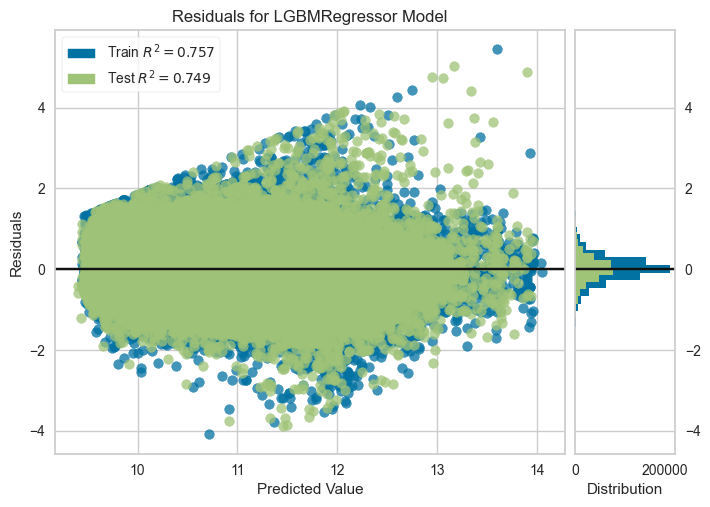

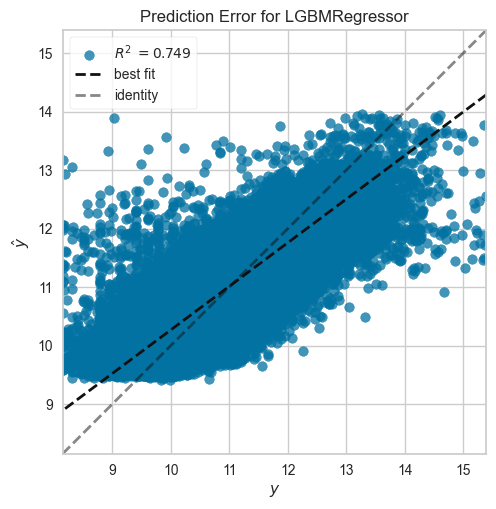


7. Saving Final Version...
Transformation Pipeline and Model Successfully Saved
Done.


In [9]:
from pycaret.regression import *
import pandas as pd
import os

# =============================================================================
# STEP 1: WAKE UP THE BODY (Load Data & Run Setup)
# ============================================================================= 
print("1. Loading and Preparing Data...")
data = pd.read_parquet('./../../data/housing/processed/price_paid_model_ready.parquet')

# --- CLEANING ---
cols_to_drop = [c for c in data.columns if 'record_status' in c]
if cols_to_drop:
    print(f"   -> Dropping problematic columns: {cols_to_drop}")
    data = data.drop(columns=cols_to_drop)

data = data.rename(columns={
    'town/city': 'town_city',
    'old/new': 'old_new',
    'ppdcategory_type': 'ppd_category'
})

# Extract Seasonality
if 'sale_month' not in data.columns:
    data['sale_month'] = data['sale_date'].dt.month

# Sample (Start small to test the fix, increase this to 0.2 or 0.5 later for better R2)
data_subset = data.sample(frac=0.05, random_state=42)

print("2. Initializing PyCaret Setup...")

potential_cats = ['property_type', 'old_new', 'duration', 'town_city', 'district', 'county', 'ppd_category']
actual_cats = [c for c in potential_cats if c in data.columns]

s = setup(
    data = data_subset,
    target = 'price', 
    session_id = 42,
    html = False,
    ignore_features = ['sale_date'],
    categorical_features = actual_cats,
    max_encoding_ohe = 20, 
    
    # --- THE CRITICAL FIXES ---
    transform_target = True,  # <--- THIS FIXES THE SKEWED RESIDUALS
    remove_outliers = True,   # Removes extreme values that confuse the model
    outliers_threshold = 0.05,
    normalize = True,
    imputation_type = 'simple' # Safety net for missing values
)

# =============================================================================
# STEP 2: CREATE FRESH MODEL (Don't load the old broken one)
# =============================================================================
print("\n3. Creating a FRESH LightGBM Model...")
# We create a new model because the old one was trained on raw prices.
# This new one will be trained on Log-Transformed prices.
lgbm = create_model('lightgbm') 

# =============================================================================
# STEP 3: TUNE
# =============================================================================
print("\n4. Tuning the Model...")
# Optimize for R2 or RMSE. Since we are using log-transform, RMSE is effectively RMSLE.
tuned_lgbm = tune_model(lgbm, optimize='R2', n_iter=20)

# =============================================================================
# STEP 4: VISUALIZE
# =============================================================================
print("\n6. Generating Plots...")
# The residuals should now look like a random cloud, not a straight line downwards
plot_model(tuned_lgbm, plot='residuals')
plot_model(tuned_lgbm, plot='error') # Added Error Plot to see prediction spread

# =============================================================================
# STEP 5: SAVE FINAL VERSION
# =============================================================================
print("\n7. Saving Final Version...")
final_pipeline = finalize_model(tuned_lgbm)

save_dir = '../../data/trained_models/housing/'
os.makedirs(save_dir, exist_ok=True)

# Save as v3 to distinguish from the broken v2
save_model(final_pipeline, os.path.join(save_dir, 'housing_pipeline_v3_log_transformed'))
print("Done.")

In [10]:
# =============================================================================
# STEP 6: SEE REAL WORLD PERFORMANCE
# =============================================================================

# 1. Run predictions on the Test Set (the 30% held back)
#    PyCaret automatically reverses the Log Transform here!
predictions = predict_model(tuned_lgbm)

# 2. Clean up the dataframe to make it readable
#    'prediction_label' is the model's guess. 'price' is the actual.
results = predictions[['price', 'prediction_label']].copy()

# 3. Calculate the error in Cash
results['Error_Amount'] = results['prediction_label'] - results['price']
results['Error_Percentage'] = (results['Error_Amount'] / results['price']) * 100

# 4. Show a random sample of 10 houses
print("\n--- Random Sample of Predictions ---")
print(results.sample(10))

# 5. Show me the "Best" and "Worst" predictions
print("\n--- Best 5 Predictions (Closest to Reality) ---")
# We use abs() because an error of -1% is just as good as +1%
print(results.iloc[results['Error_Percentage'].abs().argsort()[:5]]) 

print("\n--- Worst 5 Predictions (Biggest Failures) ---")
print(results.iloc[results['Error_Percentage'].abs().argsort()[-5:]])

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
                             Model         MAE           MSE         RMSE  \
0  Light Gradient Boosting Machine  53842.6735  3.976053e+10  199400.4185   

       R2   RMSLE    MAPE  
0  0.3614  0.3965  0.3161  

--- Random Sample of Predictions ---
           price  prediction_label   Error_Amount  Error_Percentage
16356573  107500     138404.890400   30904.890400         28.748735
11057469   88000      87383.539111    -616.460889         -0.700524
7041765    93500     105712.208221   12212.208221         13.061185
5291828    48950      56833.695689    7883.695689         16.105609
7950812    53000      81431.716200   28431.716200         53.6